In [1]:
#title **Librerías a usar:**
import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Add, Input, Reshape, multiply, Lambda, Concatenate
from keras import optimizers, regularizers
from keras.models import Model
from tensorflow.keras.regularizers import l2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils.vis_utils import plot_model
import json  ##Utilizare esta libreria para guardar objetos

In [2]:
import cv2
from keras.preprocessing.image import img_to_array
from IPython.display import Image, display
import tensorflow as tf
import matplotlib.cm as cm

In [3]:
#@title **Se carga el directorio google drive**
drive.mount('/content/drive')
!mkdir '/content/drive/MyDrive/Deep_Avan'
!mkdir '/content/drive/MyDrive/Deep_Avan/Modelos'
!mkdir '/content/drive/MyDrive/Deep_Avan/Data'
print('/content/drive/MyDrive/Deep_Avan')
Directorio = '/content/drive/MyDrive/Deep_Avan'

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/Deep_Avan’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Deep_Avan/Modelos’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Deep_Avan/Data’: File exists
/content/drive/MyDrive/Deep_Avan


In [ ]:
#title **Función de almacenamiento:**
def save_data(ruta, data,model,name, id):
  model.save(ruta+'/Modelos/model_'+name+'.h5')
  model.save_weights(ruta+'/Modelos/model_'+name+'_'+str(id)+'.h5')
  json.dump(data, open(ruta+'/Data/history_'+name+'_'+str(id)+'.js', 'w'))

def load_data(ruta,name,model_w, id):
  history = json.load(open(ruta+'/Data/history_'+name+'_'+str(id)+'.js', 'r'))
  model_w.load_weights(ruta+'/Modelos/model_'+name+'_'+str(id)+'.h5')
  model = keras.models.load_model(ruta+'/Modelos/model_'+name+'.h5')
  return model,model_w,history




In [ ]:
#@title **Dataset a utilizar**
from keras.datasets import cifar10

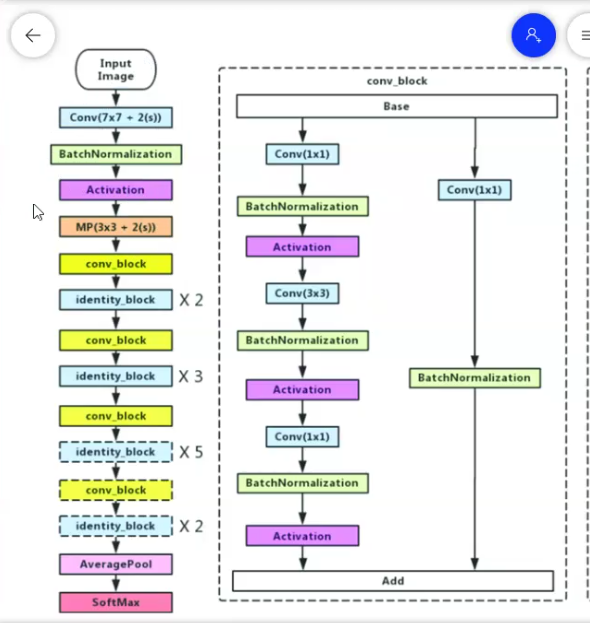

In [ ]:
#@title **Bloque inicial:** Dada la baja resolución de la imagenes en Cifar10 vamos a usar stride 1 en vez de 2 como sugerido en la restnet original.
#kz = Keras size
def initial_conv(Input, filters, stride = 1, kz = 7):
  x = Conv2D(filters, kernel_size =(kz,kz), strides=(stride,stride), 
             padding='same', use_bias=False, kernel_initializer='he_normal',
             kernel_regularizer=l2(1e-4), name='Layer_initial') (Input)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  return x

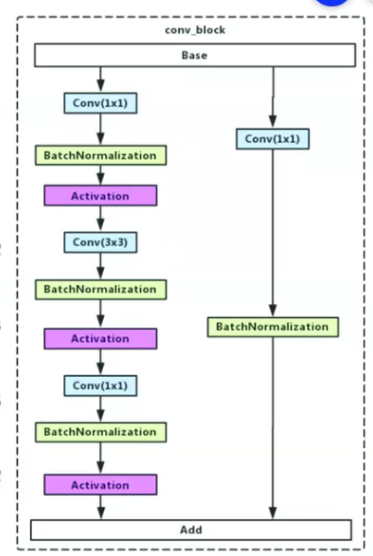

In [ ]:
#@title **Creamos la capa de conv_block**
#n valor de multiplicacion de los filtros, para escalar las dimensiones.
def conv_block_deep(Input, filters, stride, kz, n=1):
  x = Conv2D(filters*n, kernel_size=(kz,kz), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal',
             kernel_regularizer=l2(1e-4)) (Input)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  return x

def conv_block(Input, filters, stride = 1):
  #Bloque para contraer a 1*1
  x = conv_block_deep(Input, filters, stride, 1)
  #Bloque para contraer a 3*3 convolucion
  x = conv_block_deep(x, filters, stride, 3)
  #Bloque para expandir a 1*1 
  x = conv_block_deep(x, filters*4, stride, 1)
  #Bloque skip
  skip_conv = Conv2D(filters*4,kernel_size=(1,1), strides=(stride,stride),
                     padding='same', use_bias=False, kernel_initializer='he_normal') (Input)
  skip = BatchNormalization()(skip_conv)
  #Sumar los bloques"""
  x = Add()([x,skip])
  return x

  

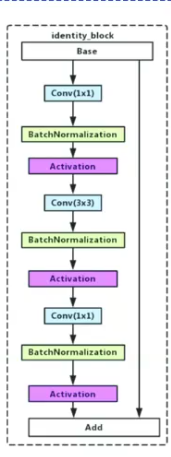

In [ ]:
#title **Creamos el bloque de identidad**

def ident_block_deep(Input, filters, stride, kz, n=1):
  x = Conv2D(filters*n, kernel_size=(kz,kz), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal') (Input)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  return x
def ident_block(Input, filters, stride = 1, se=False, cbam=False):  
  ##Bloque para contraer a 1*1
  x = ident_block_deep(Input, filters, stride, 1)
  ##Bloque para preservar a 3*3 convolucion
  x = ident_block_deep(x, filters, stride, 3)
  ##Bloque para expandar a 1*1
  x = ident_block_deep(x, filters, stride, 1, 4)

  ##Capa SE - Capa de Squeeze Excitation
  if se == True:
    x = squeeze_excite_block(x)
  ##Bloque CBAM (True/False)
  if cbam == True:
    x = cbam_block(x)
  #Sumar los bloques
  x = Add()([x, Input])
  return x

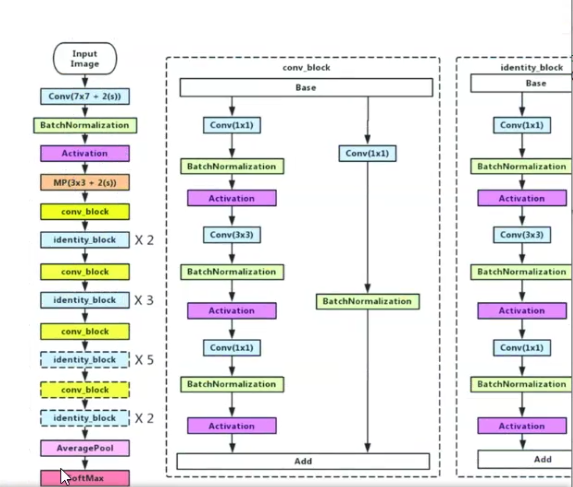

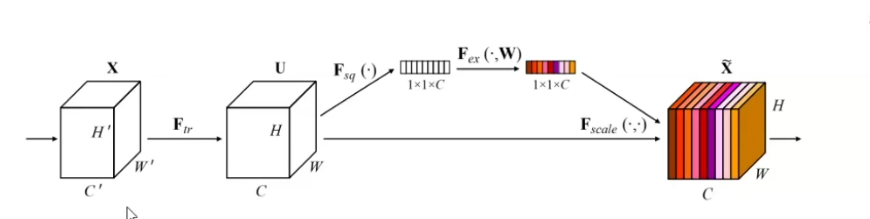


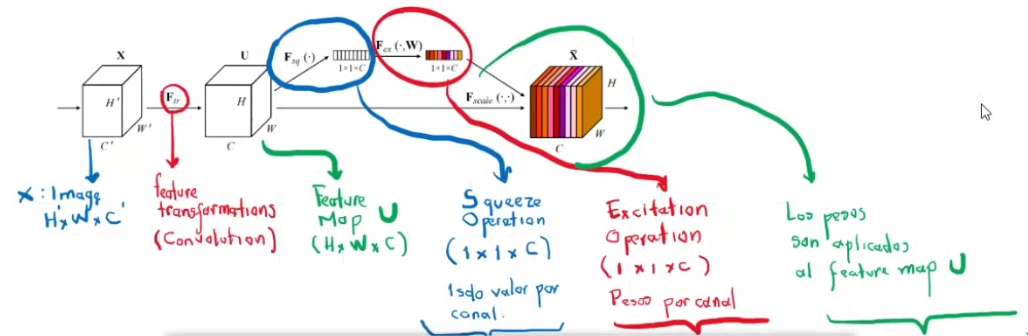

In [ ]:
#@title **Creamos el bloque de Atención**
def squeeze_excite_block(Input_t, ratio = 16):
  init = Input_t
  ##Validamos con el backend en que posición se esta guardan el canal de
  ##nuestro tensorflow.
  channel_axis = 1 if K.image_data_format()=='channel_first' else -1
  filters = init.shape[channel_axis]
  se_shape=(1,1,filters)
  se = GlobalAveragePooling2D()(init)
  se = Reshape(se_shape)(se)
  se = Dense(filters // ratio, activation='relu',
             kernel_initializer='he_normal', use_bias = False) (se)
  se = Dense(filters, activation='sigmoid',
             kernel_initializer='he_normal', use_bias = False) (se)
  x = multiply([init,se])     

  return x


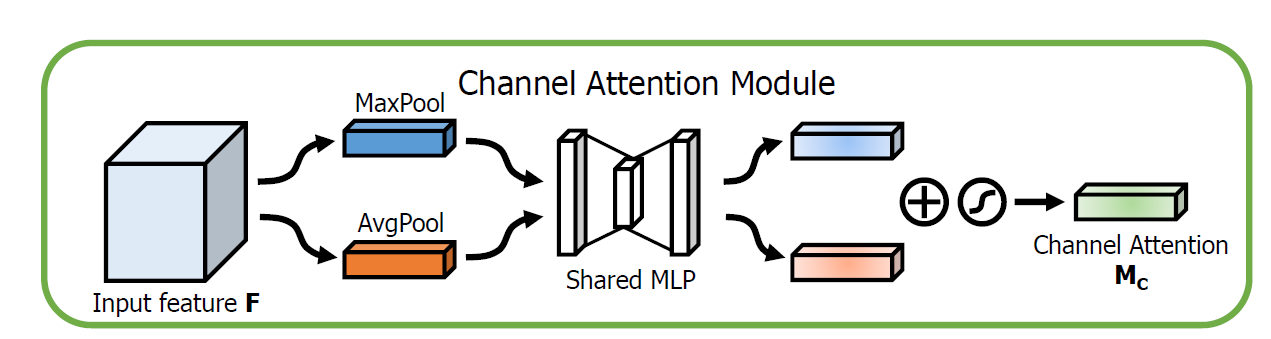

In [ ]:
#Construyendo el modulo channel attention
#input_t = Tensor se colaca 8 y no 16 porque en otro articulo da mejor resultado
def ch_attention(input_t, ratio=8):
  inputs = input_t
  channel_axis = 1 if K.image_data_format()=='channel_first' else -1
  filters = inputs.shape[channel_axis]
  #Definir la MLP compartida
  MLP_layer_S1=Dense(filters//ratio, activation='relu', 
                        kernel_initializer='he_normal', use_bias=True,
                        bias_initializer='zeros')  
  MLP_layer_S2=Dense(filters, activation='relu', 
                        kernel_initializer='he_normal', use_bias=True,
                        bias_initializer='zeros')                    
  #Definas las features del average pooling
  avg_pool = GlobalAveragePooling2D()(inputs)
  #(1x1xC)
  avg_pool = Reshape((1,1,filters))(avg_pool)
  avg_pool = MLP_layer_S1(avg_pool)
  avg_pool = MLP_layer_S2(avg_pool)
  #Definas las features del average pooling
  max_pool = GlobalMaxPooling2D()(inputs)
  #(1x1xC)
  max_pool = Reshape((1,1,filters))(max_pool)
  max_pool = MLP_layer_S1(max_pool)
  max_pool = MLP_layer_S2(max_pool)
  #Sumar los dos tipos de features y aplicarles la activación sigmoide
  cbam_feat_ch = Add()([avg_pool, max_pool])
  cbam_feat_ch = Activation('sigmoid')(cbam_feat_ch)
  cbam_feat_ch = multiply([inputs,cbam_feat_ch])
  return cbam_feat_ch


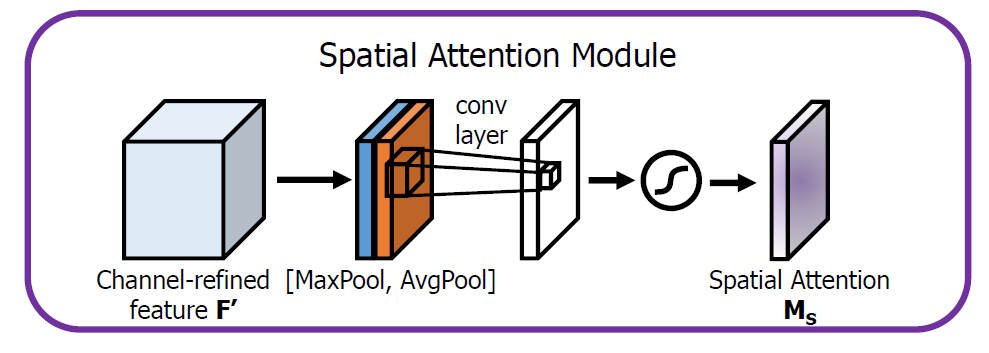

In [ ]:
def sp_attention(input_t, kz=7):
  inputs = input_t
  ##Con Lamba definimos un función sin llamado donde x el parametro y 
  # depues : definimos el cuerpo de la función.
  # Se define que saque el promedio sobre todos los canales.
  # keepdims mantenemos las dimensiones del parametri de entrada.
  avg_pool = Lambda(lambda x: K.mean(x,axis=3, keepdims=True))(inputs)
  max_pool = Lambda(lambda x: K.max(x,axis=3, keepdims=True))(inputs)
  concat = Concatenate(axis=3)([avg_pool,max_pool])

  cbam_feat_sp = Conv2D(filters=1, kernel_size=kz, strides=1, padding='same',
                        activation='sigmoid', kernel_initializer='he_normal',
                        use_bias=False)(concat)
  cbam_feat_sp = multiply([inputs,cbam_feat_sp])
  return cbam_feat_sp
  

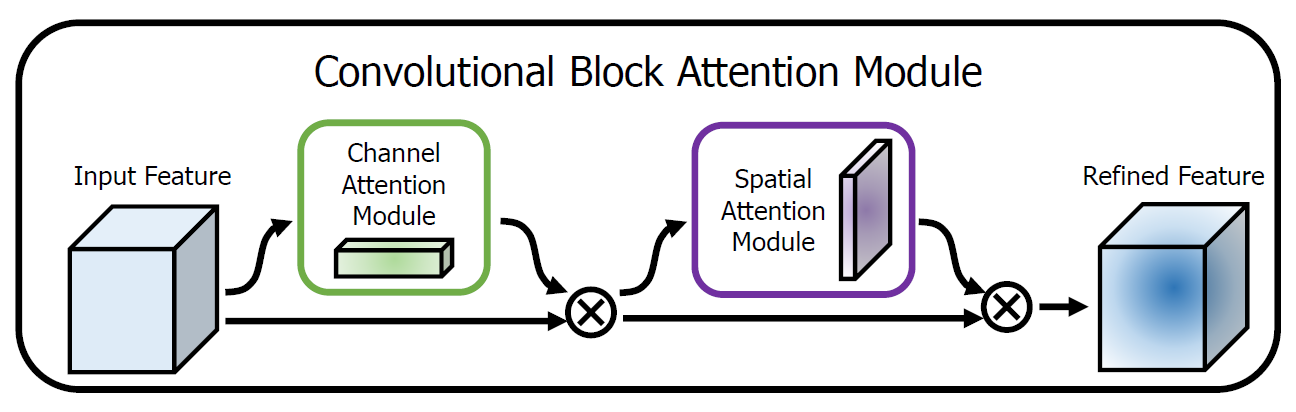

In [ ]:
def cbam_block(input_t):
  init = input_t
  cbam_feat_ch = ch_attention(init)
  cbam_feat    = sp_attention(cbam_feat_ch)
  return cbam_feat


In [ ]:
#title **Crear las ResNet50**
##Cambiamos los primero parametros de la primera capa de 7x7 kernel size 2 a 1x1 kz = 7
def build_resnet50(h,w,n_outputs,r1,r2,r3,r4, 
                   first_conv_stride=1, first_conv_kernek_size=7, se = False, cbam = False):
  #Crear el tensor de entrada:
  inputs = Input(shape=(h,w,3), name='image_input')
  
  #Bloque inicial (usamos 64 filtros)
  x = initial_conv(inputs, 64, first_conv_stride, first_conv_kernek_size)
  x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding=('same')) (x)
  #Bloque de convolucion 1
  x = conv_block(x, 64, 1)
  x = Activation('relu')(x)
  
  #Bloque de identidad r1 (64 filtros):
  for i in range(r1-1):
    x = ident_block(x,64,1, se, cbam)
    x = Activation(activation='relu')(x)
  
  #Bloque de convolucion 2 (128 filtros)
  x = conv_block(x,128,1)
  x = Activation('relu')(x)
  #Bloque de identidad r2:
  for i in range(r2-1):
    x = ident_block(x,128,1, False, cbam)
    x = Activation(activation='relu')(x)  
  
  #Bloque de convolucion 3 (256 filtros)
  x = conv_block(x,256,1)
  x = Activation('relu')(x)
  #Bloque de identidad r3:
  for i in range(r3-1):
    x = ident_block(x,256,1, False, cbam)
    x = Activation(activation='relu')(x)  
  
  #Bloque de convolucion 4 (512 filtros)
  x = conv_block(x,512, 1)
  x = Activation('relu')(x)
  #Bloque de identidad r4:
  for i in range(r4-1):
    x = ident_block(x,512,1, False, cbam)
    x = Activation(activation='relu')(x)  
  
  ##Utilizamos el backend de keras para retornar el shape del tensor.
  shape = K.int_shape(x) 
  x = AveragePooling2D(pool_size=(shape[1],shape[2]), strides=(1,1)) (x)
  
  ##Creamos la capa softmax desde una capa densa, funciona muy bien así:
  x = Flatten()(x) ##Primero hacemos un aplanado.
  x = Dense(n_outputs, activation='softmax')(x) ##Capa de salida softmax
  
  ##Creamos el modelo:
  model = Model(inputs=inputs, outputs=x)
  
  return model

In [ ]:
#@title **Se carga la arquitectura:** Sin modelo de atención
#Dimensiones de 32x32 porque cifar10 tiene estas dimensiones
#Numero de salidas 10 porque cifar10 se clasifica en 10 grupos.
model1 = build_resnet50(32,32,10,3,4,6,3,1,7)

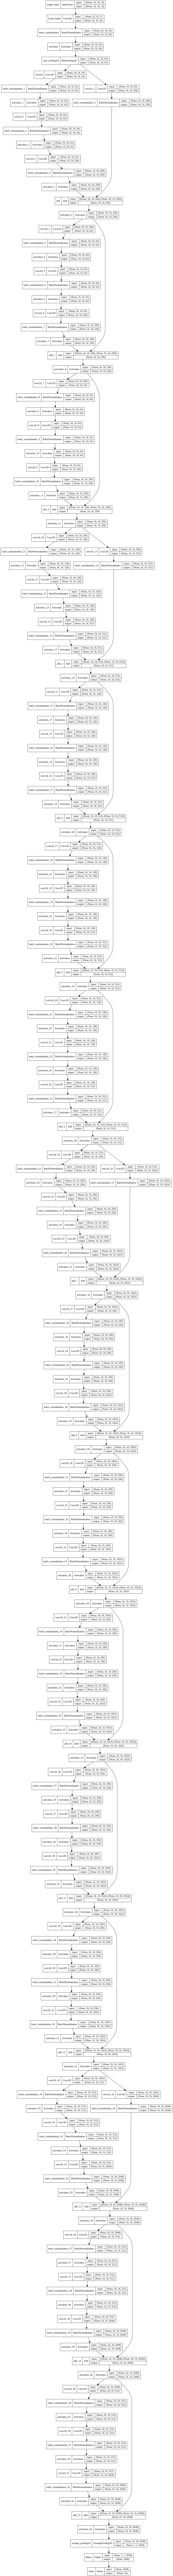

In [ ]:
#@title **Se visualiza la arquitectura**
plot_model(model1, Directorio+'/ResNet50_v2.png', show_shapes=True)

In [4]:
#@title **Se carga el data Cifar 10**
#Montar el dataset Cifar 10
from keras.datasets import cifar10
from keras.preprocessing.image import array_to_img

In [5]:
(x_train, y_train), (x_test, y_test)=cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


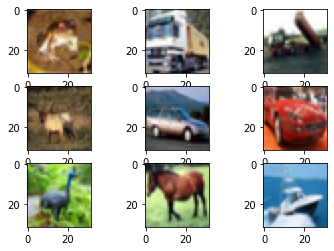

In [ ]:
#@title **Visualizamos imagnes del data set:***
for i in range (0,9):
  plt.subplot (3,3, i+1)
  plt.imshow(array_to_img(x_train[i]))
plt.show()

In [6]:
#@title Ajustes iniciales del data set:
##Se cambia el tipo de datos de los data set a flotante de 32 bits.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

##Se normaliza los valores del data set:
x_train = x_train / 255
x_test = x_test /255


In [7]:
#@title se realiza preprocesamiento de los datos con Z-score
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
##Se calcula la media de data set de entrenamiento
mean = np.mean(x_train,axis=(0,1,2,3))
##Se calcula la deviación estándar del data set de entrenamiento
std = np.std(x_train,axis=(0,1,2,3))
##Se resta la media y se divida la devición estándar de los data set
# de pruebas y entrenamiento. 
###NOTA: se suma un valor muy pequeño en la división para evitar división x 0
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [8]:
#@title Se aplica one hot enconding a los target o label de los data set:
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [9]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
#title **Entrenamiento**
#batch_size = 10#64
batch_size = 64
#epochs = 1#20
epochs = 10

#history = model1.fit(x_train[0:10], y_train[0:10], batch_size=batch_size*4, epochs=epochs, validation_data=(x_test[0:10], y_test[0:10]), verbose=1)
history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10


In [ ]:
#@title Se almacena la información del entrenamiento:

History = history.history
#Guardamos los datos importantes del entrenamiento:
save_data(Directorio,History,model1,'restnet50',10)
print('\n')
print(f'Almacenamiento completado en el directorio {Directorio}')

In [ ]:
#@title **Se carga la información:** ***!!!NOTA:!!!*** Sólo usar si solo se requiere cargar el modelo y sus resultados sin haber entrenado.
model_L, model1, History = load_data(Directorio,'restnet50',model1,1 )

In [ ]:
# title Se gráfica la información del entrenamiento
###Gráfica de Accuracy
plt.plot(History['accuracy'])
plt.plot(History['val_accuracy'])
plt.title('Modelo Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'], loc='upper left')
plt.show()

###Gráfica loss
plt.plot(History['loss'])
plt.plot(History['val_loss'])
plt.title('Modelo Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
#@title **Se carga la arquitectura:** Con modelo de atención
#Dimensiones de 32x32 porque cifar10 tiene estas dimensiones
#Numero de salidas 10 porque cifar10 se clasifica en 10 grupos.
model2 = build_resnet50(32,32,10,3,4,6,3,1,7, True)

In [ ]:
# OJO!!  1. SE CARGO EL MODELO DE 10 EPOCAS
model2 = keras.models.load_model('/content/drive/MyDrive/Deep_Avan/Modelos/model_SE_restnet50.h5')

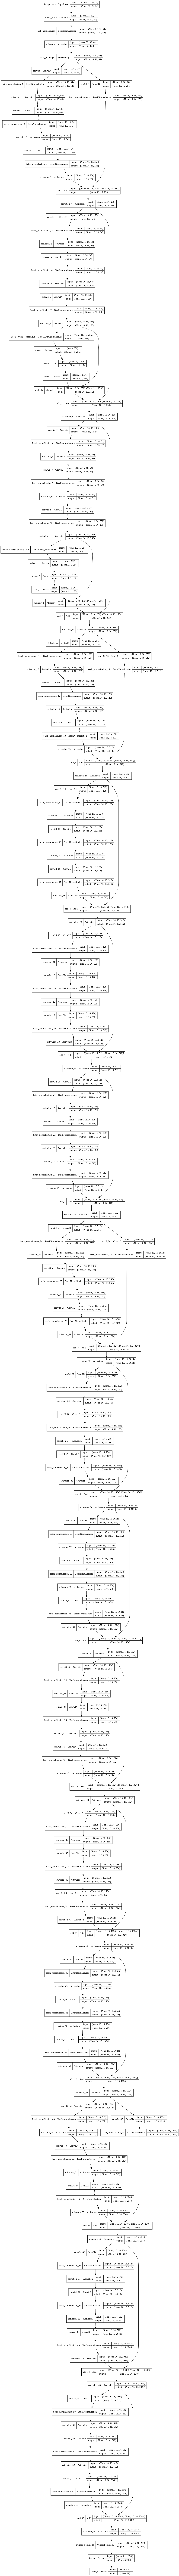

In [ ]:
#@title **Se visualiza la arquitectura** !!
plot_model(model2, Directorio+'/SE_ResNet50.png', show_shapes=True)

cargo el model para epoca 20 ....

In [ ]:
model2 = keras.models.load_model('/content/drive/MyDrive/Deep_Avan/Modelos/model_SE_restnet50.h5')

In [ ]:
#title **Entrenamiento**

#model2.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])  #OJO SE COMENTA 

##batch_size = 10#64
# epochs = 20
batch_size = 64
epochs = 10

##history2 = model2.fit(x_train[0:10], y_train[0:10], batch_size=batch_size*4, epochs=epochs, validation_data=(x_test[0:10], y_test[0:10]), verbose=1)
history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
782/782 [==============================] - 1077s 1s/step - loss: 0.3932 - accuracy: 0.8959 - val_loss: 0.6804 - val_accuracy: 0.8112
Epoch 2/10
782/782 [==============================] - 1074s 1s/step - loss: 0.3586 - accuracy: 0.9064 - val_loss: 0.9850 - val_accuracy: 0.7465
Epoch 3/10
  5/782 [..............................] - ETA: 17:00 - loss: 0.3448 - accuracy: 0.9156

In [ ]:
v

In [ ]:
#@title Se almacena la información del entrenamiento:

History2 = history2.history
#Guardamos los datos importantes del entrenamiento:
save_data(Directorio,History2,model2,'SE_restnet50',20)  # ,1 es la cant epoca y guarda js
print('\n')
print(f'Almacenamiento completado en el directorio {Directorio}')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)




Almacenamiento completado en el directorio /content/drive/MyDrive/Deep_Avan


In [ ]:
#@title **Se carga la información:** ***!!!NOTA:!!!*** Sólo usar si solo se requiere cargar el modelo y sus resultados sin haber entrenado.
model2, History2 = load_data(Directorio,'SE_restnet50')

In [ ]:
#@title Se gráfica la información del entraneminto.
###Gráfica de Accuracy
plt.plot(History2['accuracy'])
plt.plot(History2['val_accuracy'])
plt.title('Modelo Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'], loc='upper left')
plt.show()

###Gráfica loss
plt.plot(History2['loss'])
plt.plot(History2['val_loss'])
plt.title('Modelo Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
#title **Se carga la arquitectura:** Con modelo de atención
#Dimensiones de 32x32 porque cifar10 tiene estas dimensiones
#Numero de salidas 10 porque cifar10 se clasifica en 10 grupos.
model_att = build_resnet50(32,32,10,3,4,6,3,1,7, False, True)

In [ ]:
#@title **Se carga la información:** ***!!!NOTA:!!!*** Sólo usar si solo se requiere cargar el modelo y sus resultados sin haber entrenado.
model_att, model_att_w, History = load_data(Directorio,'Att_restnet50',model_att,1 )

In [ ]:
model_att.summary()

In [ ]:
#@title **Se visualiza la arquitectura**
plot_model(model_att, Directorio+'/Attention_ResNet50.png', show_shapes=True)

In [ ]:
adam =keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                            epsilon=None, decay=1e-6, amsgrad=False)
model_att.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])


In [ ]:
batch_size = 64
epochs = 10

In [ ]:
#title **Entrenamiento**
history3 = model_att.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                         validation_data=(x_test, y_test), verbose=1)

In [ ]:
#@title Se almacena la información del entrenamiento:
History3 = history3.history
#Guardamos los datos importantes del entrenamiento:
save_data(Directorio,History3,model_att,'Att_restnet50',1)
print('\n')
print(f'Almacenamiento completado en el directorio {Directorio}')

In [10]:
#@title **Algortimo de GradCAM para visualizacion**
#Author: fchollet
#Libro: Deep Learning with Python (2017)
#Description: How to obtain a class activation heatmap for an image classification model.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, 
                         model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [11]:
#@title Función de visualización Gradcam
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    

In [12]:
#@title **Función de carga de los modelos almacenados:**
def load_data_nw(ruta,name):
  history = json.load(open(ruta+'/Data/history'+name+'.js', 'r'))  
  model = keras.models.load_model(ruta+'/Modelos/model'+name+'.h5')  
  return model,history  

In [13]:
#@title **Directorio repositorio Tarea***
Directorio = '/content/drive/MyDrive/Deep_Avan'

print(Directorio)

/content/drive/MyDrive/Deep_Avan


In [14]:
#@title Se carga modelo **Resnet50 Original** previamente entrenado:
model_ori= keras.models.load_model('/content/drive/MyDrive/Resnet50_SE_CBAM/Modelos/modelRestNet50.h5')


In [15]:
#@title Se carga modelo **Resnet50 SE** previamente entrenado:
model_se= keras.models.load_model('/content/drive/MyDrive/Resnet50_SE_CBAM/Modelos/modelRestNet50SE.h5')

In [16]:
#@title Se carga modelo **Resnet50 Adam** previamente entrenado:
model_se_adam= keras.models.load_model('/content/drive/MyDrive/Resnet50_SE_CBAM/Modelos/model_SE_restnet50_ADAM.h5')

In [17]:
#@title Se carga modelo **Resnet50 CBAM** previamente entrenado:
model_cbam= keras.models.load_model('/content/drive/MyDrive/Resnet50_SE_CBAM/Modelos/modelRestNet50CBAM.h5')


In [18]:
#@title Etiquetas del data set de CIFAR10
etiquetas = np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
print(etiquetas)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [21]:
#print(Directorio)
Dir_img = Directorio+'/img/'
preprocess_input = keras.applications.xception.preprocess_input

img_array = preprocess_input(get_img_array(Dir_img+'avion1.jpg', size=(32,32)))
img_array = img_array.astype('float32')/255.0
mean=np.mean(img_array,axis=(0,1,2,3))
std = np.std(img_array, axis=(0,1,2,3))
img_array = (img_array - mean)/(std+1e-7)

img_array2 = preprocess_input(get_img_array(Dir_img+'barco1.jpg', size=(32,32)))
img_array2 = img_array2.astype('float32')/255.0
mean=np.mean(img_array2,axis=(0,1,2,3))
std = np.std(img_array2, axis=(0,1,2,3))
img_array2 = (img_array2 - mean)/(std+1e-7)

img_array3 = preprocess_input(get_img_array(Dir_img+'caballo1.jpg', size=(32,32)))
img_array3 = img_array3.astype('float32')/255.0
mean=np.mean(img_array3,axis=(0,1,2,3))
std = np.std(img_array3, axis=(0,1,2,3))
img_array3 = (img_array3 - mean)/(std+1e-7)

img_array4 = preprocess_input(get_img_array(Dir_img+'camion1.jpg', size=(32,32)))
img_array4 = img_array4.astype('float32')/255.0
mean=np.mean(img_array4,axis=(0,1,2,3))
std = np.std(img_array4, axis=(0,1,2,3))
img_array4 = (img_array4 - mean)/(std+1e-7)

img_array5 = preprocess_input(get_img_array(Dir_img+'ciervo1.jpg', size=(32,32)))
img_array5 = img_array5.astype('float32')/255.0
mean=np.mean(img_array5,axis=(0,1,2,3))
std = np.std(img_array5, axis=(0,1,2,3))
img_array5 = (img_array5 - mean)/(std+1e-7)

img_array6 = preprocess_input(get_img_array(Dir_img+'gato1.jpg', size=(32,32)))
img_array6 = img_array6.astype('float32')/255.0
mean=np.mean(img_array6,axis=(0,1,2,3))
std = np.std(img_array6, axis=(0,1,2,3))
img_array6 = (img_array6 - mean)/(std+1e-7)

img_array7 = preprocess_input(get_img_array(Dir_img+'pajaro1.jpg', size=(32,32)))
img_array7 = img_array7.astype('float32')/255.0
mean=np.mean(img_array7,axis=(0,1,2,3))
std = np.std(img_array7, axis=(0,1,2,3))
img_array7 = (img_array7 - mean)/(std+1e-7)

img_array8 = preprocess_input(get_img_array(Dir_img+'perro1.jpg', size=(32,32)))
img_array8 = img_array8.astype('float32')/255.0
mean=np.mean(img_array8,axis=(0,1,2,3))
std = np.std(img_array8, axis=(0,1,2,3))
img_array8 = (img_array8 - mean)/(std+1e-7)

img_array9 = preprocess_input(get_img_array(Dir_img+'rana1.jpg', size=(32,32)))
img_array9 = img_array9.astype('float32')/255.0
mean=np.mean(img_array9,axis=(0,1,2,3))
std = np.std(img_array9, axis=(0,1,2,3))
img_array9 = (img_array9 - mean)/(std+1e-7)

img_array10 = preprocess_input(get_img_array(Dir_img+'carro1.jpg', size=(32,32)))
img_array10 = img_array10.astype('float32')/255.0
mean=np.mean(img_array10,axis=(0,1,2,3))
std = np.std(img_array10, axis=(0,1,2,3))
img_array10 = (img_array10 - mean)/(std+1e-7)


pred1 = model_ori.predict(img_array)  ##Caballo Original
pred2 = model_se.predict(img_array)   ##Caballo SE
pred3 = model_cbam.predict(img_array) ##Caballo CBAM
pred4 = model_se_adam.predict(img_array) ##Caballo SE-ADAM

pred12 = model_ori.predict(img_array2)  ##Pajaro Original
pred22 = model_se.predict(img_array2)   ##Pajaro SE
pred32 = model_cbam.predict(img_array2) ##Pajaro CBAM
pred42 = model_se_adam.predict(img_array2) ##Pajaro SE-ADAM

pred13 = model_ori.predict(img_array3)  ##Rana Original
pred23 = model_se.predict(img_array3)   ##Rana SE
pred33 = model_cbam.predict(img_array3) ##Rana CBAM
pred43 = model_se_adam.predict(img_array3) ##Rana SE-ADAM

pred14 = model_ori.predict(img_array4)  ##Rana Original
pred24 = model_se.predict(img_array4)   ##Rana SE
pred34 = model_cbam.predict(img_array4) ##Rana CBAM
pred44 = model_se_adam.predict(img_array4) ##Rana SE-ADAM

pred15 = model_ori.predict(img_array5)  ##Rana Original
pred25 = model_se.predict(img_array5)   ##Rana SE
pred35 = model_cbam.predict(img_array5) ##Rana CBAM
pred45 = model_se_adam.predict(img_array5) ##Rana SE-ADAM

pred16 = model_ori.predict(img_array6)  ##Rana Original
pred26 = model_se.predict(img_array6)   ##Rana SE
pred36 = model_cbam.predict(img_array6) ##Rana CBAM
pred46 = model_se_adam.predict(img_array6) ##Rana SE-ADAM

pred17 = model_ori.predict(img_array7)  ##Rana Original
pred27 = model_se.predict(img_array7)   ##Rana SE
pred37 = model_cbam.predict(img_array7) ##Rana CBAM
pred47 = model_se_adam.predict(img_array7) ##Rana SE-ADAM

pred18 = model_ori.predict(img_array8)  ##Rana Original
pred28 = model_se.predict(img_array8)   ##Rana SE
pred38 = model_cbam.predict(img_array8) ##Rana CBAM
pred48 = model_se_adam.predict(img_array8) ##Rana SE-ADAM

pred19 = model_ori.predict(img_array9)  ##Rana Original
pred29 = model_se.predict(img_array9)   ##Rana SE
pred39 = model_cbam.predict(img_array9) ##Rana CBAM
pred49 = model_se_adam.predict(img_array9) ##Rana SE-ADAM

pred110 = model_ori.predict(img_array10)  ##Rana Original
pred210 = model_se.predict(img_array10)   ##Rana SE
pred310 = model_cbam.predict(img_array10) ##Rana CBAM
pred410 = model_se_adam.predict(img_array10) ##Rana SE-ADAM



In [22]:
heatmap1 = make_gradcam_heatmap(img_array,model_ori,'activation_64' )
heatmap2 = make_gradcam_heatmap(img_array,model_se,'activation_47' )
heatmap3 = make_gradcam_heatmap(img_array,model_cbam,'activation_76' ) 
heatmap4 = make_gradcam_heatmap(img_array,model_se_adam,'activation_129' )

heatmap12 = make_gradcam_heatmap(img_array2,model_ori,'activation_64' )
heatmap22 = make_gradcam_heatmap(img_array2,model_se,'activation_47' )
heatmap32 = make_gradcam_heatmap(img_array2,model_cbam,'activation_76' )
heatmap42 = make_gradcam_heatmap(img_array2,model_se_adam,'activation_129' )

heatmap13 = make_gradcam_heatmap(img_array3,model_ori,'activation_64' )
heatmap23 = make_gradcam_heatmap(img_array3,model_se,'activation_47' )
heatmap33 = make_gradcam_heatmap(img_array3,model_cbam,'activation_76' )
heatmap43 = make_gradcam_heatmap(img_array3,model_se_adam,'activation_129' )

heatmap14 = make_gradcam_heatmap(img_array4,model_ori,'activation_64' )
heatmap24 = make_gradcam_heatmap(img_array4,model_se,'activation_47' )
heatmap34 = make_gradcam_heatmap(img_array4,model_cbam,'activation_76' )
heatmap44 = make_gradcam_heatmap(img_array4,model_se_adam,'activation_129' )

heatmap15 = make_gradcam_heatmap(img_array5,model_ori,'activation_64' )
heatmap25 = make_gradcam_heatmap(img_array5,model_se,'activation_47' )
heatmap35 = make_gradcam_heatmap(img_array5,model_cbam,'activation_76' )
heatmap45 = make_gradcam_heatmap(img_array5,model_se_adam,'activation_129' )

heatmap16 = make_gradcam_heatmap(img_array6,model_ori,'activation_64' )
heatmap26 = make_gradcam_heatmap(img_array6,model_se,'activation_47' )
heatmap36 = make_gradcam_heatmap(img_array6,model_cbam,'activation_76' )
heatmap46 = make_gradcam_heatmap(img_array6,model_se_adam,'activation_129' )

heatmap17 = make_gradcam_heatmap(img_array7,model_ori,'activation_64' )
heatmap27 = make_gradcam_heatmap(img_array7,model_se,'activation_47' )
heatmap37 = make_gradcam_heatmap(img_array7,model_cbam,'activation_76' )
heatmap47 = make_gradcam_heatmap(img_array7,model_se_adam,'activation_129' )

heatmap18 = make_gradcam_heatmap(img_array8,model_ori,'activation_64' )
heatmap28 = make_gradcam_heatmap(img_array8,model_se,'activation_47' )
heatmap38 = make_gradcam_heatmap(img_array8,model_cbam,'activation_76' )
heatmap48 = make_gradcam_heatmap(img_array8,model_se_adam,'activation_129' )

heatmap19 = make_gradcam_heatmap(img_array9,model_ori,'activation_64' )
heatmap29 = make_gradcam_heatmap(img_array9,model_se,'activation_47' )
heatmap39 = make_gradcam_heatmap(img_array9,model_cbam,'activation_76' )
heatmap49 = make_gradcam_heatmap(img_array9,model_se_adam,'activation_129' )

heatmap110 = make_gradcam_heatmap(img_array10,model_ori,'activation_64' )
heatmap210 = make_gradcam_heatmap(img_array10,model_se,'activation_47' )
heatmap310 = make_gradcam_heatmap(img_array10,model_cbam,'activation_76' )
heatmap410 = make_gradcam_heatmap(img_array10,model_se_adam,'activation_129' )



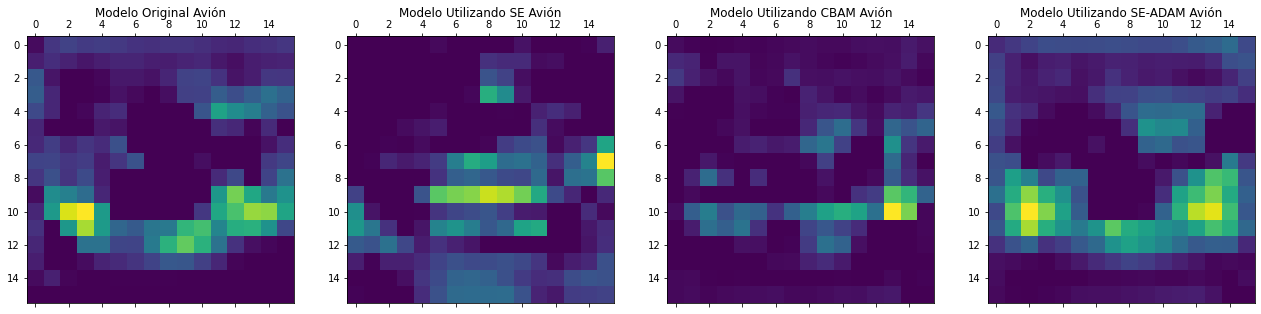

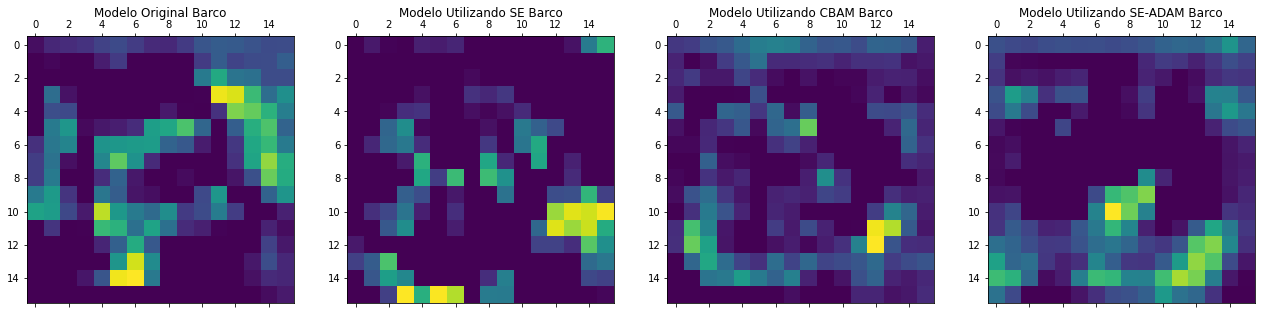

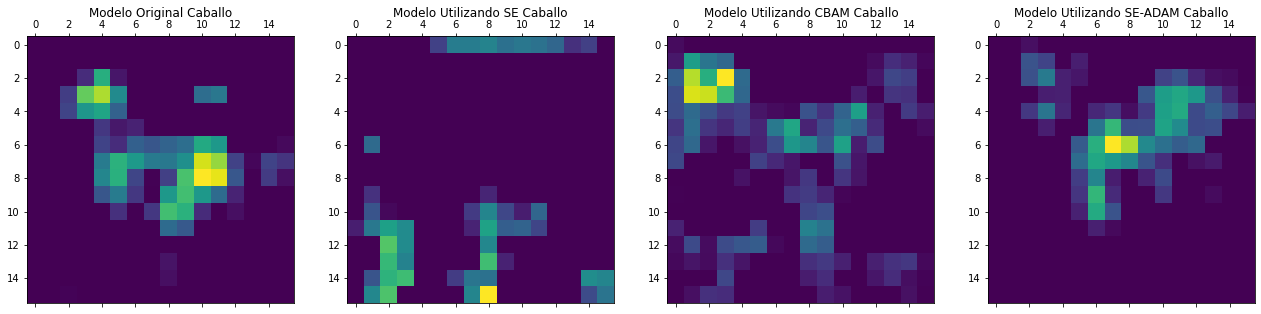

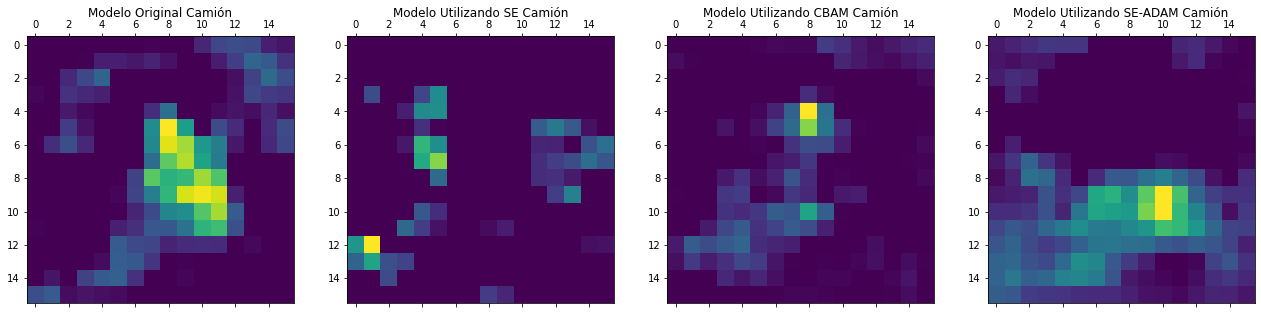

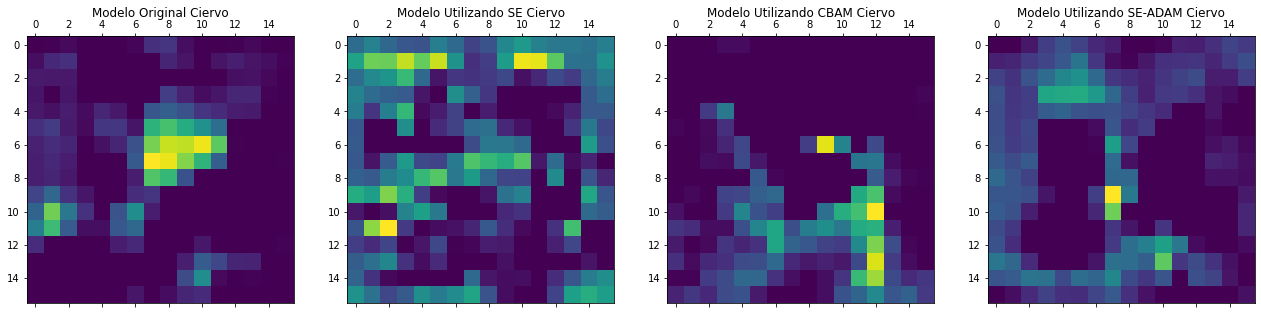

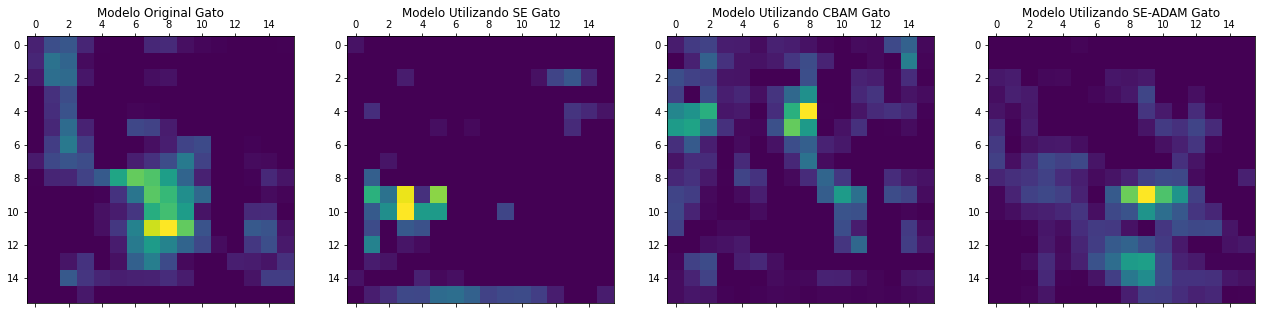

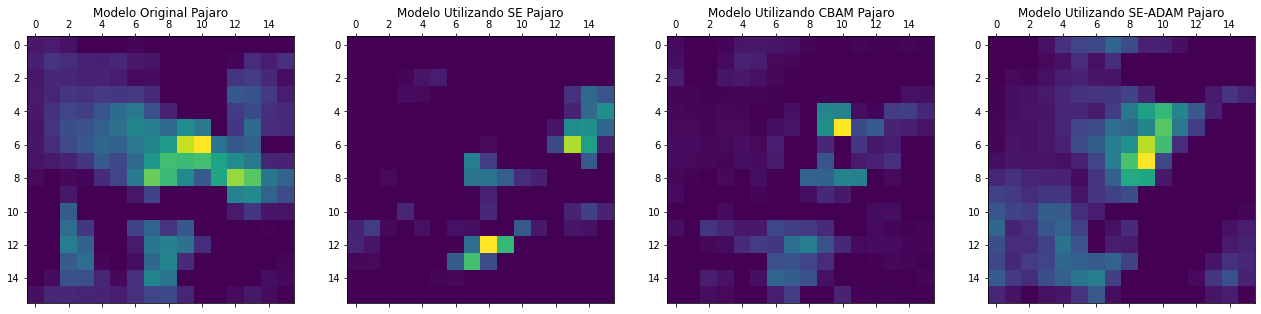

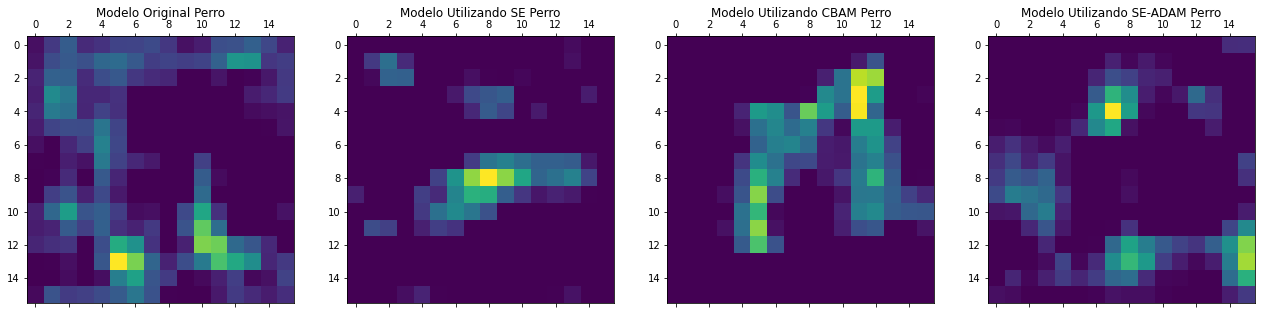

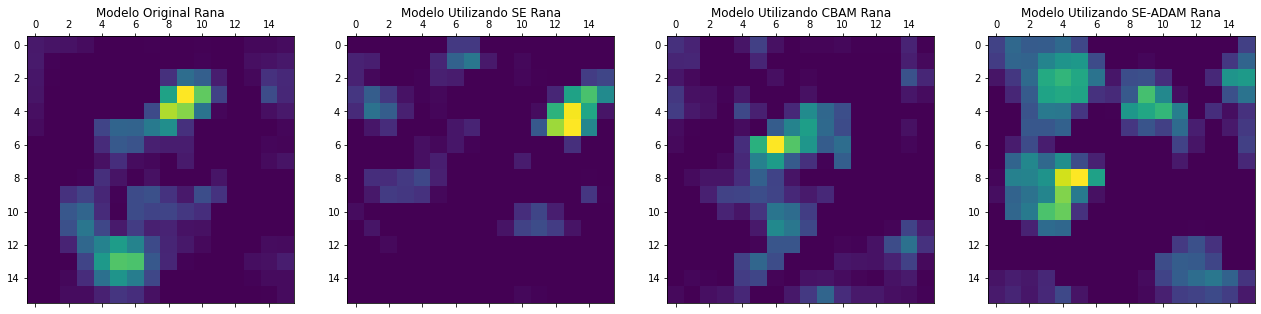

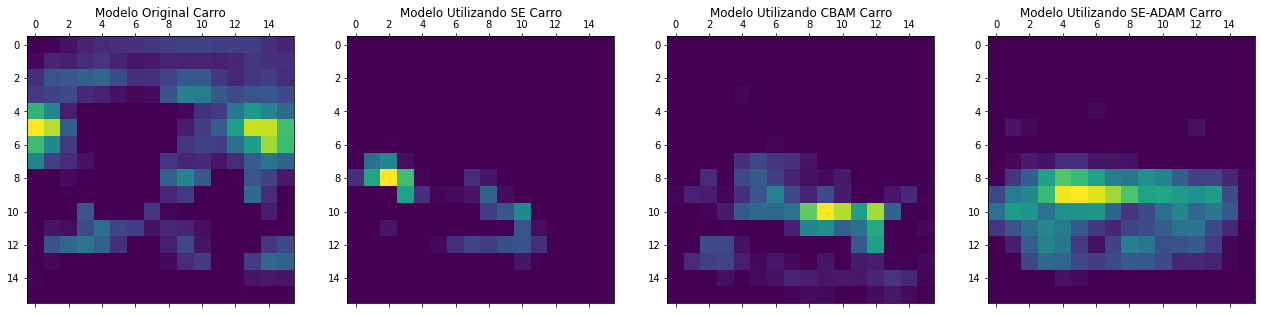

In [23]:
#@title **Se gráfica heatmap de los modelos con la imagen de prueba:**

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Avión')
plt.matshow(heatmap1,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Avión')
plt.matshow(heatmap2,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Avión')
plt.matshow(heatmap3, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Avión')
plt.matshow(heatmap4, fignum=False)

plt.show()


plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Barco' )
plt.matshow(heatmap12,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Barco')
plt.matshow(heatmap22,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Barco')
plt.matshow(heatmap32, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Barco')
plt.matshow(heatmap42, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Caballo')
plt.matshow(heatmap13,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Caballo')
plt.matshow(heatmap23,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Caballo')
plt.matshow(heatmap33, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Caballo')
plt.matshow(heatmap43, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Camión')
plt.matshow(heatmap14,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Camión')
plt.matshow(heatmap24,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Camión')
plt.matshow(heatmap34, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Camión')
plt.matshow(heatmap44, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Ciervo')
plt.matshow(heatmap15,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Ciervo')
plt.matshow(heatmap25,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Ciervo')
plt.matshow(heatmap35, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Ciervo')
plt.matshow(heatmap45, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Gato')
plt.matshow(heatmap16,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Gato')
plt.matshow(heatmap26,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Gato')
plt.matshow(heatmap36, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Gato')
plt.matshow(heatmap46, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Pajaro')
plt.matshow(heatmap17,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Pajaro')
plt.matshow(heatmap27,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Pajaro')
plt.matshow(heatmap37, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Pajaro')
plt.matshow(heatmap47, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Perro')
plt.matshow(heatmap18,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Perro')
plt.matshow(heatmap28,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Perro')
plt.matshow(heatmap38, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Perro')
plt.matshow(heatmap48, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Rana')
plt.matshow(heatmap19,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Rana')
plt.matshow(heatmap29,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Rana')
plt.matshow(heatmap39, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Rana')
plt.matshow(heatmap49, fignum=False)

plt.show()

plt.figure(figsize=(22,15))
plt.subplot(1,4,1)
plt.title('Modelo Original Carro')
plt.matshow(heatmap110,fignum=False)

plt.subplot(1,4,2)
plt.title('Modelo Utilizando SE Carro')
plt.matshow(heatmap210,fignum=False)

plt.subplot(1,4,3)
plt.title('Modelo Utilizando CBAM Carro')
plt.matshow(heatmap310, fignum=False)

plt.subplot(1,4,4)
plt.title('Modelo Utilizando SE-ADAM Carro')
plt.matshow(heatmap410, fignum=False)

plt.show()



Modelo Original



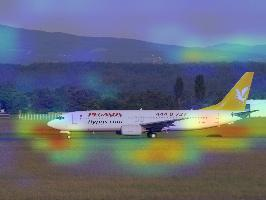

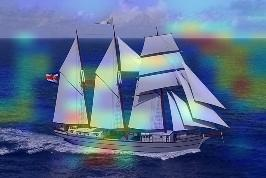

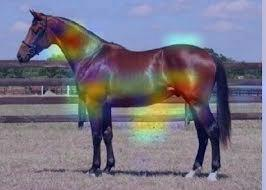

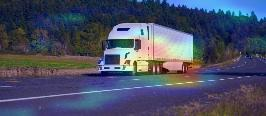

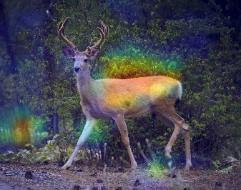

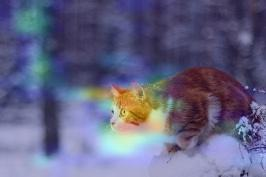

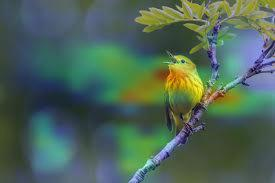

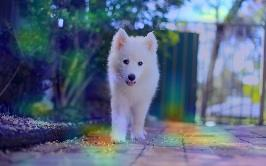

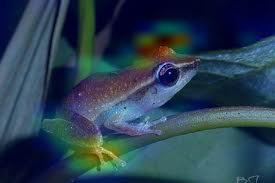

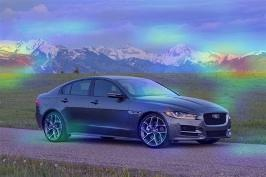


Modelo con SE



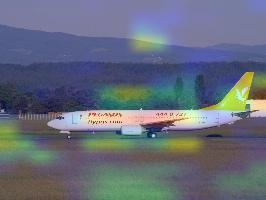

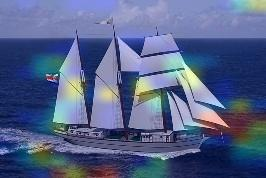

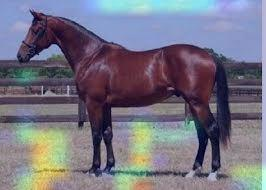

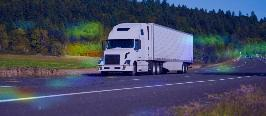

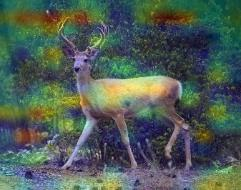

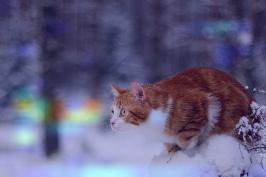

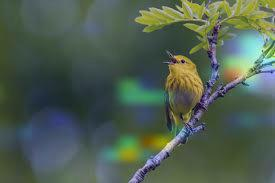

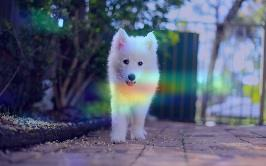

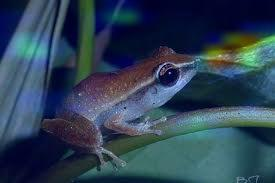

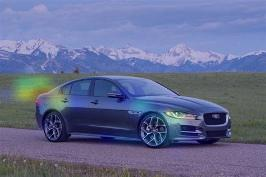


Modelo con CBAM



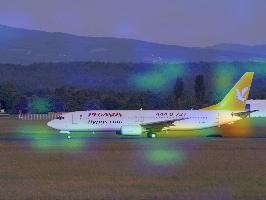

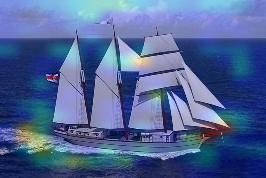

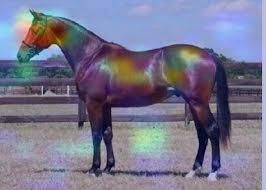

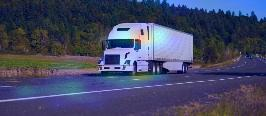

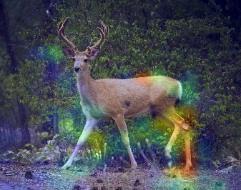

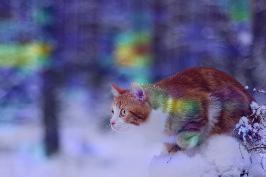

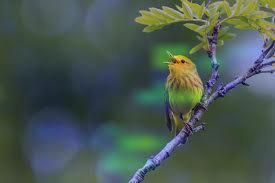

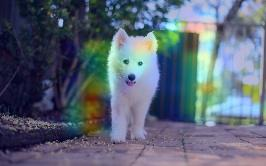

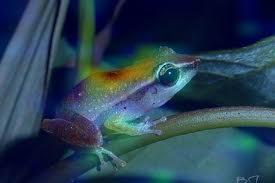

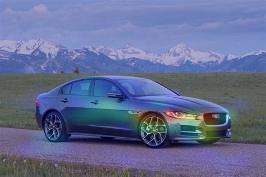


Modelo con SE-ADAM



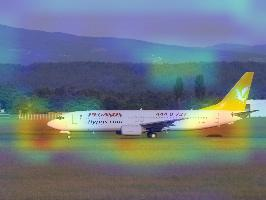

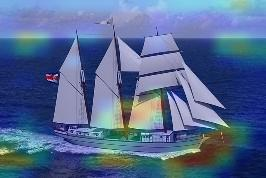

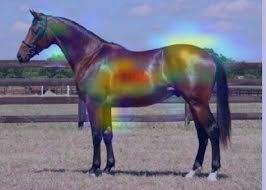

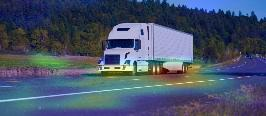

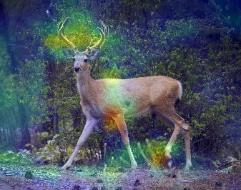

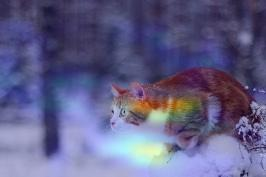

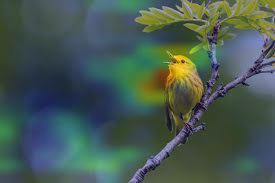

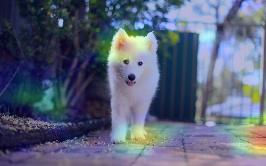

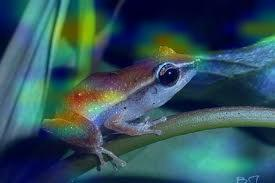

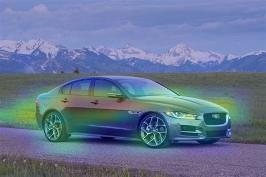

<Figure size 1584x1080 with 0 Axes>

In [25]:
plt.figure(figsize=(22,15))
print("Modelo Original")
print()
save_and_display_gradcam(Dir_img+'avion1.jpg',
                         heatmap1, 
                         Dir_img+'avion1_Ori.jpg')
print()
save_and_display_gradcam(Dir_img+'barco1.jpg',
                         heatmap12, 
                         Dir_img+'barco1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'caballo1.jpg',
                         heatmap13, 
                         Dir_img+'caballo1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'camion1.jpg',
                         heatmap14, 
                         Dir_img+'camion1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'ciervo1.jpg',
                         heatmap15, 
                         Dir_img+'ciervo1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'gato1.jpg',
                         heatmap16, 
                         Dir_img+'gato1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'pajaro1.jpg',
                         heatmap17, 
                         Dir_img+'pajaro1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'perro1.jpg',
                         heatmap18, 
                         Dir_img+'perro1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'rana1.jpg',
                         heatmap19, 
                         Dir_img+'rana1_ori.jpg')
print()
save_and_display_gradcam(Dir_img+'carro1.jpg',
                         heatmap110, 
                         Dir_img+'carro1_ori.jpg')


print()
print("Modelo con SE")
print()
save_and_display_gradcam(Dir_img+'avion1.jpg',
                         heatmap2, 
                         Dir_img+'avion1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'barco1.jpg',
                         heatmap22, 
                         Dir_img+'barco1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'caballo1.jpg',
                         heatmap23, 
                         Dir_img+'caballo1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'camion1.jpg',
                         heatmap24, 
                         Dir_img+'camion1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'ciervo1.jpg',
                         heatmap25, 
                         Dir_img+'ciervo1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'gato1.jpg',
                         heatmap26, 
                         Dir_img+'gato1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'pajaro1.jpg',
                         heatmap27, 
                         Dir_img+'pajaro1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'perro1.jpg',
                         heatmap28, 
                         Dir_img+'perro1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'rana1.jpg',
                         heatmap29, 
                         Dir_img+'rana1_Se.jpg')
print()
save_and_display_gradcam(Dir_img+'carro1.jpg',
                         heatmap210, 
                         Dir_img+'carro1_Se.jpg')

print()
print("Modelo con CBAM")
print()
save_and_display_gradcam(Dir_img+'avion1.jpg',
                         heatmap3, 
                         Dir_img+'avion1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'barco1.jpg',
                         heatmap32, 
                         Dir_img+'barco1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'caballo1.jpg',
                         heatmap33, 
                         Dir_img+'caballo1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'camion1.jpg',
                         heatmap34, 
                         Dir_img+'camion1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'ciervo1.jpg',
                         heatmap35, 
                         Dir_img+'ciervo1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'gato1.jpg',
                         heatmap36, 
                         Dir_img+'gato1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'pajaro1.jpg',
                         heatmap37, 
                         Dir_img+'pajaro1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'perro1.jpg',
                         heatmap38, 
                         Dir_img+'perro1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'rana1.jpg',
                         heatmap39, 
                         Dir_img+'rana1_CBAM.jpg')
print()
save_and_display_gradcam(Dir_img+'carro1.jpg',
                         heatmap310, 
                         Dir_img+'carro1_CBAM.jpg')

print()
print("Modelo con SE-ADAM")
print()
save_and_display_gradcam(Dir_img+'avion1.jpg',
                         heatmap4, 
                         Dir_img+'avion1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'barco1.jpg',
                         heatmap42, 
                         Dir_img+'barco1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'caballo1.jpg',
                         heatmap43, 
                         Dir_img+'caballo1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'camion1.jpg',
                         heatmap44, 
                         Dir_img+'camion1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'ciervo1.jpg',
                         heatmap45, 
                         Dir_img+'ciervo1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'gato1.jpg',
                         heatmap46, 
                         Dir_img+'gato1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'pajaro1.jpg',
                         heatmap47, 
                         Dir_img+'pajaro1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'perro1.jpg',
                         heatmap48, 
                         Dir_img+'perro1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'rana1.jpg',
                         heatmap49, 
                         Dir_img+'rana1_SE_ADAM.jpg')
print()
save_and_display_gradcam(Dir_img+'carro1.jpg',
                         heatmap410, 
                         Dir_img+'carro1_SE_ADAM.jpg')